# BB84 protocol implementation using Pennylane
<sub>by Giulia LM</sub> 


Quantum Key Distribution (QKD) is one of the most advanced applications of quantum cryptography, allowing secure keys to be generated between two parties over a quantum channel. The first and most famous protocol proposed by Bennett and Brassard in 1984
 


## Protocol outline

Suppose Alice, the sender, wants to generate and share an encryption key with Bob, but cannot do so over the classical channel because Eve, an eavesdropper, has access to it.

<div align="center">
  <img src="images/channels.png" alt="drawing" width="500"/> 
    <p> Diagram of BB84. Alice and Bob communicate using a quantum channel and a classical channel, with Eve interfering in both.<p/>
</div>

Alice then generates a random set of bits, and for each one, chooses a diagonal or rectangular basis (x, +) with which to prepare the photon. She sends the photons to Bob over the quantum channel. Bob receives them and measures them using a random basis, collapsing each qubit into a state. If Bob chose the same basis as Alice, he will obtain the bit Alice chose. However, if Bob chooses a different basis, the probability of obtaining the prepared bit is 50%. 

<div align="center">
  <img src="images/basis.png" alt="drawing" width="500" /> 
    <p> Representation of Bob's probability of getting the bit sent by Alice in the case where they use the same and different bases.<p/>
</div>

Over the classical channel, Alice and Bob compare the bases they used and only retain the bits where they match, obtaining the final key. If Eve intercepts a qubit, she alters the states by measuring with incorrect bases, revealing her presence.

## Implementation with pennylane


In [229]:
import pennylane as qml
import random

The "default.mixed" device allows us to introduce noise to the channel:

In [230]:
dev = qml.device("default.mixed", wires=1, shots=1)

The protocol was split into two circuits—one for the Alice-Eve part and one for Bob—because in quantum computing, once a qubit is measured, its state collapses, preventing further measurements on the same qubit without altering the outcome.

In [231]:
@qml.qnode(dev)
def alice_eve_circuit(alice_bit, aliceBasis, eveBasis, p):
    #alice prepares her bits
    if alice_bit == 1:
        qml.PauliX(wires=0)
    if aliceBasis == 'x':
        qml.Hadamard(wires=0)

    # introducing noise into the channel with probability p
    qml.DepolarizingChannel(p ,wires =0)
    qml.BitFlip(p ,wires =0)

    # eve meassures 
    if eveBasis == 'x':
        qml.Hadamard(wires=0)

    eve_bit = qml.sample(wires=0)

    return eve_bit

In [232]:
@qml.qnode(dev)
def eve_bob_circuit(eve_bit, eveBasis, bobBasis, p):
   # eve reprepares according to what she measured
    if eve_bit == 1:
        qml.PauliX(wires=0)
    if eveBasis == 'x':
        qml.Hadamard(wires=0)

    qml.DepolarizingChannel(p ,wires =0)
    qml.BitFlip(p ,wires =0)

    # bob measures
    if bobBasis == 'x':
        qml.Hadamard(wires=0)
    return qml.sample(wires=0)

In [233]:
def bb84(n, p, p_range=[0.6,0.4], sample=True):
    bob_bits = []
    eve_bits = []
    bob_sifted = []
    alice_sifted = []
    
    alice_bits = [random.choices([0, 1], weights=p_range)[0] for _ in range(n)]
    aliceBasis = [random.choices(['+', 'x'], weights=p_range)[0] for _ in range(n)]
    bobBasis = [random.choices(['+', 'x'], weights=p_range)[0] for _ in range(n)]
    eveBasis = [random.choices(['+', 'x'], weights=p_range)[0] for _ in range(n)]

    for i in range(n):
        eve_bit = int(alice_eve_circuit(alice_bits[i], aliceBasis[i], eveBasis[i], p))
        bob_bit = int(eve_bob_circuit(eve_bit, eveBasis[i], bobBasis[i], p))
        eve_bits.append(eve_bit)
        bob_bits.append(bob_bit)

    for i in range(n):
        if aliceBasis[i] == bobBasis[i]:
            bob_sifted.append(bob_bits[i])
            alice_sifted.append(alice_bits[i])

    # option for visualizing or just sampling
    if sample:
        return alice_sifted, bob_sifted, eve_bits
    else:
        return aliceBasis, alice_bits, bobBasis, bob_bits, eveBasis, eve_bits, alice_sifted, bob_sifted

### Testing the protocol

In [234]:
import pandas as pd

In [235]:
n = 16
noise_p = 0.01
p_range = [0.6,0.4]

aliceBasis, alice_bits, bobBasis, bob_bits, eveBasis, eve_bits, alice_sifted, bob_sifted = bb84(n, noise_p, p_range, False)

data = [aliceBasis, alice_bits, bobBasis, bob_bits, eveBasis, eve_bits]

rows = [
    "Alice basis",
    "Alice sended bits",
    "Bob measuring basis",
    "Bob measured bits",
    "Eve Basis",
    "Eve measured bits"
]

df = pd.DataFrame(data, index=rows)
df.columns = [''] * df.shape[1]

print(df)
print("\nAlices's key:",alice_sifted)
print("Bob's key:   ",bob_sifted)

                                                                   
Alice basis          x  x  x  +  x  +  x  +  x  +  +  +  x  +  +  +
Alice sended bits    0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0
Bob measuring basis  +  +  x  +  +  x  x  x  +  x  +  x  +  +  +  +
Bob measured bits    0  0  0  0  1  1  1  0  0  1  1  0  1  0  0  0
Eve Basis            +  x  x  x  x  x  +  +  +  +  +  +  +  x  +  x
Eve measured bits    0  0  0  1  0  1  1  0  0  0  1  0  1  1  0  0

Alices's key: [0, 0, 0, 1, 0, 0, 0]
Bob's key:    [0, 0, 1, 1, 0, 0, 0]


In this example, Alice and Bob only keep the results where they used the same basis. The only cases where their bits differ are: (1) when Eve uses a different basis and alters the qubit, causing Bob to measure a random bit, and (2) when the result changes due to introduced noise.

---

**Channel security check**

An additional step just to check the error between Alice's and Bob's final key after the privacy amplification step, if the error rate exceeds a predefined threshold, the communication is terminated to ensure security.

In [236]:
def is_secure(threshold, alice_final_key, bob_final_key):
    error = sum(e != k for e,k in zip(alice_final_key, bob_final_key))/len(alice_final_key)
    if error < threshold:
        return True
    else:
        return False

In [237]:
is_secure(0.4, alice_final_key, bob_final_key)

True

## Applying different methods to evaluate the security of the protocol
### Eve's guessing probability

In [238]:
def guessing_p(eve_bits, final_key):
    eve_bits = "".join(str(b) for b in eve_bits)
    correct_eve_guesses = sum(e == k for e,k in zip(eve_bits, final_key))
    guess_p = correct_eve_guesses / len(final_key)

    return guess_p

In [239]:
final_len = 8
g_eve = gen_random_hasher(2**final_len)
eve_final_key = privacy_amplification(g_eve, eve_bits, final_len)
guessing_p(eve_final_key, alice_final_key)

0.375

### Entropy calculation: H(A), H(B), H(E) 

In [240]:
from collections import Counter
from scipy.stats import entropy
from math import log
import numpy as np
from itertools import product

In [241]:
def shannon_entropy(bits):
    entropy = 0
    reps = Counter(bits)
    for element in reps:
        p = reps[element] / len(bits)
        entropy -= p * math.log2(p)
    
    return entropy

Conditional Entropy
<div align="center">
  <img src="images/condH.png" alt="drawing" width="300"/> 
</div>
H(A|B) measures how uncertain we are about a variable A given that we already know B

In [242]:
def conditional_entropy(X,Y):
    conjuntion = zip(X,Y)
    conjuntion_counter = Counter(conjuntion)
    freq_total_conjuntion = np.sum(list(conjuntion_counter.values()))

    Y_count = Counter(Y)
    freq_total_Y = np.sum(list(Y_count.values()))

    h = 0
    for x,y in product(np.unique(X),np.unique(Y)):
        if conjuntion_counter[(x,y)] != 0:
            h += (conjuntion_counter[(x,y)]/freq_total_conjuntion)*np.log2((Y_count[y]/freq_total_Y)/(conjuntion_counter[(x,y)]/freq_total_conjuntion))

    return h


### Mutual information
Quantifies how much information two variables share, I(A;B) measures how much does knowing B reduce uncertainty about A, and vice versa.

In [243]:
def mutual_inf(X, Y):
    return shannon_entropy(X) - conditional_entropy(X, Y) 

Testing the metrics:

In [244]:
eves_guess_p = guessing_p(eve_bits, bob_final_key)

h_A = shannon_entropy(alice_sifted)
h_B = shannon_entropy(bob_sifted)
h_E = shannon_entropy(eve_bits)

hA_E = conditional_entropy(alice_sifted, eve_bits)
hB_E = conditional_entropy(bob_sifted, eve_bits)

I_AE = mutual_inf(alice_sifted, eve_bits)
I_BE = mutual_inf(bob_sifted, eve_bits)

eveluation = [eves_guess_p, h_E, hA_E, hB_E,I_AE, I_BE]
rows = [
    "Eve's guessing p",
    "H(E)",
    "H(A|E)",
    "H(B|E)",
    "I(A;E)",
    "I(B;E)"
]
df = pd.DataFrame(eveluation, index=rows)
df.columns = [''] * df.shape[1]
df

,
Eve's guessing p,0.312500
H(E),0.954434
H(A|E),0.384869
H(B|E),0.848457
I(A;E),0.206804
I(B;E),0.014664


## Results

In [245]:
eves_guessing_p = []
condH_BobEve = []
condH_AlEve = []
MI_AlEve = []
MI_BobEve = []


m = 500
n = 64
noise_p = 0.01
final_len = 32
p_range=[0.6,0.4]

channel_sec = 0.4

for i in range(m):
    alice_sifted, bob_sifted, eve_bits = bb84(n, noise_p, p_range)

    if not is_secure(channel_sec, alice_sifted, bob_sifted):
        pass

    eves_guessing_p.append(guessing_p(eve_bits, alice_sifted))

    condH_AlEve.append(conditional_entropy(alice_sifted, eve_bits))
    condH_BobEve.append(conditional_entropy(bob_sifted, eve_bits))

    MI_AlEve.append(mutual_inf(alice_sifted, eve_bits))
    MI_BobEve.append(mutual_inf(bob_sifted, eve_bits))

The protocol was run 500 times with 64-bit keys and a quantum noise channel of 0.3 to evaluate its robustness.

## Visualizations

In [246]:
import matplotlib.pyplot as plt

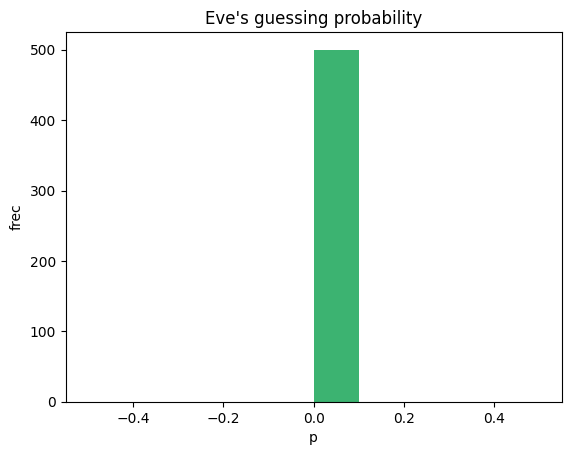

In [247]:
plt.hist(eves_guessing_p, color='mediumseagreen')
plt.title("Eve's guessing probability")
plt.xlabel("p")
plt.ylabel("frec")
 
plt.show()

The histogram help us see that the probability that Eve guesses the final key it's always 0%, wich assure us that the protocol is safe.

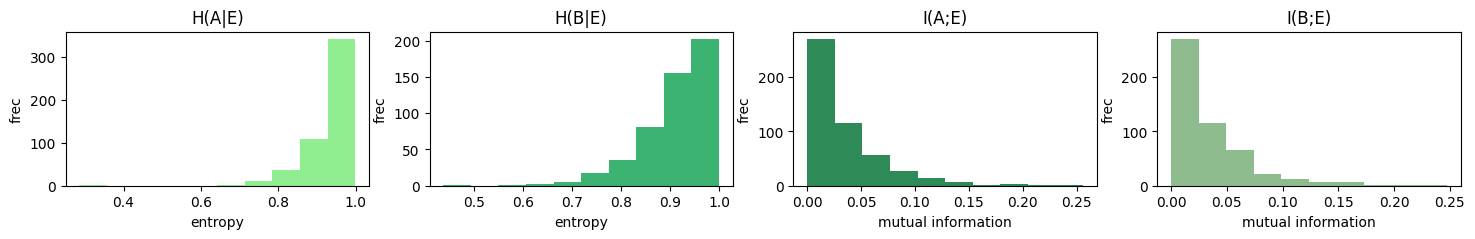

In [248]:
fig, axs = plt.subplots(1, 4, figsize=(18, 2))

axs[0].hist(condH_BobEve, color='lightgreen')
axs[0].set_title("H(A|E)")

axs[0].set_xlabel('entropy')

axs[1].hist(condH_AlEve, color='mediumseagreen')
axs[1].set_title("H(B|E)")
axs[1].set_xlabel('entropy')
axs[2].hist(MI_AlEve, color='seagreen')
axs[2].set_title("I(A;E)")
axs[2].set_xlabel('mutual information')
axs[3].hist(MI_BobEve, color='darkseagreen')
axs[3].set_title("I(B;E)")
axs[3].set_xlabel('mutual information')

for ax in axs.flat:
    ax.set(ylabel='frec')

The histograms show that Eve's conditional entropy with respect to Alice and Bob is close to 100%, while her mutual information with both Alice and Bob is close to 0%. This indicates that Eve gains virtually no useful information from either the system or the final key.